# Autoencoders: Ejemplo LFW

[Aumentar resolución](https://medium.com/analytics-vidhya/super-resolution-using-autoencoders-and-tf2-0-505215c1674)

In [1]:
import cv2
#importar pandas para manejo de dataframes
import pandas as pd
# import tarfile para manejo de archivos comprimidos
import tarfile
# Barra de progreso
from tqdm.notebook import tqdm
# Manejo de archivos del computador
import os
# Manejo de gráficos
import matplotlib.pyplot as plt
# Manejo de Arreglos
import numpy as np
 

##  Descargar los datos 

In [2]:

!wget --no-check-certificate \
  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz \
  -O /tmp/lfw-deepfunneled.tgz

!wget --no-check-certificate \
  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt \
  -O /tmp/lfw_attributes.txt

!wget --no-check-certificate \
  http://vis-www.cs.umass.edu/lfw/lfw.tgz \
  -O /tmp/lfw.tgz
  


--2021-05-11 23:51:14--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘/tmp/lfw-deepfunneled.tgz’

/tmp/lfw-deepfunnel 100%[===================>] 103.72M  33.4MB/s    in 3.3s    

2021-05-11 23:51:17 (31.8 MB/s) - ‘/tmp/lfw-deepfunneled.tgz’ saved [108761145/108761145]

--2021-05-11 23:51:17--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-05-11 23:51:17--  https://

In [4]:
import os 
import zipfile



In [5]:
ATTRS_NAME = '/tmp/lfw_attributes.txt'
IMAGES_NAME = '/tmp/lfw-deepfunneled.tgz'
RAW_IMAGES_NAME = '/tmp/lfw.tgz'

## Funciones para leer y preprocesar los datos usando OpenCV

In [6]:
## Función  para decodificar las imágenes bajadas desde datos crudos (bytes)
def decode_image_from_raw_bytes(raw_bytes):
    # Decodificar desde archivos crudos en formato adecuado, flag =1 significa leer en BGR
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    #Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

## Procesamiento individual

In [7]:
indice=2
with tarfile.open(RAW_IMAGES_NAME) as f:
    m=f.getmembers()[indice]
    print(m)
    img=decode_image_from_raw_bytes(f.extractfile(m).read())
    print(img.shape)

<TarInfo 'lfw/George_HW_Bush/George_HW_Bush_0001.jpg' at 0x7f66cb29d940>
(250, 250, 3)


In [8]:
with tarfile.open(RAW_IMAGES_NAME) as f:
  m=f.getmembers()[indice]
  raw_bytes=f.extractfile(m).read()
  print(bytearray(raw_bytes)[:10])

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF')


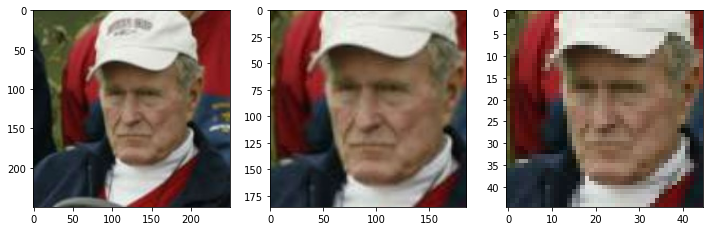

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(img)

dx=32
dy=32
img_new=img[dx:-dx,dy:-dy]
plt.subplot(132)
plt.imshow(img_new)

dimx=45
dimy=45

img_new = cv2.resize(img_new, (dimx, dimy))
plt.subplot(133)
plt.imshow(img_new)

plt.show()

In [10]:
## Función para bajar las imagenes del .tgz y preprocesarlas sistemáticamente
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Leer archivo lfw_attributes.txt y hacer una limpieza inicial
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    # Corrimiento de carácteres incorrectos
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    # Filtrar nombres de personas y numeros de imagen (por persona), convertir a conjunto
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Leer Fotos e identificación
    all_photos = []
    photo_ids = []

    # Abrir archivo .tgz sin descomprimir
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        # tqdm se usa para mostrar la barra de progreso
        for m in tqdm(f.getmembers()):
            # Solo procesa los archivos desde el archivo comprimido que sean realmente imágenes (.jpg)
            if m.isfile() and m.name.endswith(".jpg"):
                # Descomprimir archivo desde el comprimido y convertir a RGB
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Recortar lo que sean caras y cambiar tamaño
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Obtener nombre de la persona y agregarlo a la colección de datos
                fname = os.path.split(m.name)[-1]
                # La razón de -4 es para quitar la extensión .jpg
                fname_splitted = fname[:-4].replace('_', ' ').split()
                # Sacar la identificación del nombre
                person_id = ' '.join(fname_splitted[:-1])
                # Sacar el número de foto por separado
                photo_number = int(fname_splitted[-1])
                # Comparar los metadatos con las fotos reales (DEBEN COINCIDIR)
                if (person_id, photo_number) in imgs_with_attrs:
                    # Cuando coinciden, agregar las fotos
                    all_photos.append(img)
                    # Y también agregar la identidad de las personas
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
                    
    # Hacer un dataframe con los resultados
    photo_ids = pd.DataFrame(photo_ids)
    # UNir las imágenes en un tensor 4D
    all_photos = np.stack(all_photos).astype('uint8')

    # Preservar el orden de encontrados en búsqueda
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs, photo_ids

In [97]:
# Obtener el conjunto de datos sin descomprimir
dim_x=80
dim_y=80
X, attr,names = load_lfw_dataset(use_raw=True, dimx=dim_x, dimy=dim_y)

In [98]:
X.shape

(13143, 80, 80, 3)

In [13]:
attr.shape

(13143, 73)

In [14]:
names.shape

(13143, 2)

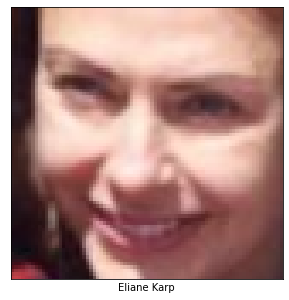

In [99]:
azar = np.random.randint(len(X))
plt.figure(figsize=(5,5))
plt.imshow(X[azar])
plt.xticks([])
plt.yticks([])
plt.xlabel(names.person[azar])
plt.show()

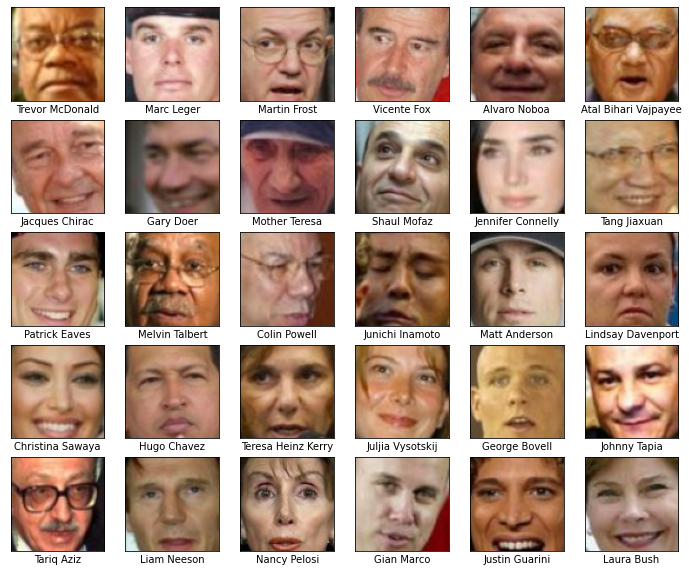

In [100]:
plt.figure(figsize=(12,10))
numero_muestras = 30

muestras=np.random.randint(0,len(X), numero_muestras)

for i in range(numero_muestras):
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[muestras[i]])
  plt.xlabel(names.person[muestras[i]])
plt.show()


## Normalizar los datos

In [101]:
X = X.astype('float32')/255.
X.shape

(13143, 80, 80, 3)

## Convertir imagenes a escala de grises

In [103]:
X_gray = X[..., :3]@[0.299,0.587,0.114]
print(X_gray.shape)



(13143, 80, 80)


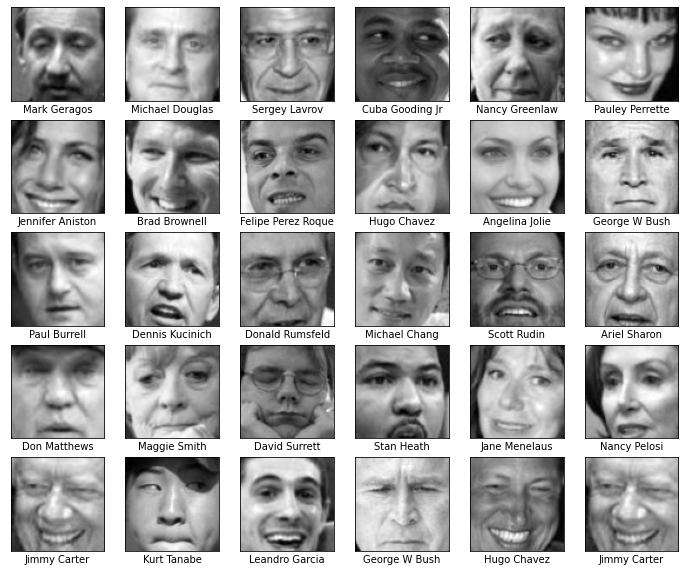

In [104]:
plt.figure(figsize=(12,10))
numero_muestras = 30

muestras=np.random.randint(0,len(X_gray), numero_muestras)

for i in range(numero_muestras):
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_gray[muestras[i]], cmap='gray')
  plt.xlabel(names.person[muestras[i]])
plt.show()


In [105]:
# Agregar dimensión para la entrada
X_gray = np.expand_dims(X_gray, axis=3)
print(X_gray.shape)

(13143, 80, 80, 1)


## Importar módulos 

In [106]:
# Importar tensorflow
import tensorflow as tf 
# importar layers apropiados para la Red
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose # Para realizar deconvolución 
from tensorflow.keras.models import Model
# Graficar modelo
from tensorflow.keras.utils import plot_model
# Importar optimizadores
from tensorflow.keras.optimizers import Adam, Adamax
# Importar Función de Pérdida
from tensorflow.keras.losses import MeanSquaredError
# Función parar separar datos de entrenamiento y validación
from sklearn.model_selection import train_test_split
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

 

## Parámetros de la red Codificadora

In [107]:
 print(X_gray.shape)
 print(X.shape)

(13143, 80, 80, 1)
(13143, 80, 80, 3)


In [108]:
# Van a entrar x_train.shape[1] filas, x_train.shape[2] columnas y x_train.shape[3] canales de color
rows = X.shape[1]
cols =  X.shape[2]
channels = X.shape[3]

input_shape = (rows, cols, 1)
batch_size = 256
kernel_size = 2
latent_dim = 1024
epochs = 20

layer_filters = [16,32,64,1024]

## Codificador: encoder

In [109]:
inputs = Input(shape=input_shape)
x = inputs 
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size= kernel_size,
             strides = 2,
             activation = 'relu',
             padding = 'same')(x)
# Guardar la forma del decoder
shape = x.shape.as_list()

x = Flatten()(x)
latent = Dense(latent_dim, name = 'Latenet_Vector')(x)
encoder_colorizing = Model(inputs, latent, name = 'Encoder_Colorizing')

Model: "Encoder_Colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 40, 40, 16)        80        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 20, 20, 32)        2080      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 64)        8256      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 5, 5, 1024)        263168    
_________________________________________________________________
flatten_9 (Flatten)          (None, 25600)             0         
_________________________________________________________________
Latenet_Vector (Dense)       (None, 1024)       

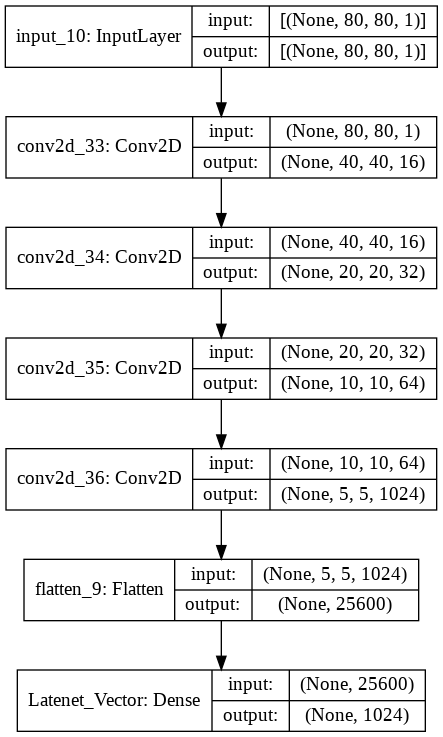

In [110]:
encoder_colorizing.summary()
plot_model(encoder_colorizing, show_shapes=True)

In [27]:
(shape[1]*shape[2]*shape[3])
shape[3]
latent_dim
channels

3

# Decodificador: decoder

In [95]:
latent_inputs = Input(shape= (latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)
#Deconvolución  
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation = 'relu',
                      padding = 'same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=2,
                          activation = 'sigmoid',
                          padding = 'same',
                          
                          name =  'decoder_output')(x)

decoder_colorizing = Model(latent_inputs, outputs, name = 'decoder_colorizing')

Model: "decoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 1024)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 25600)             26240000  
_________________________________________________________________
reshape_12 (Reshape)         (None, 5, 5, 1024)        0         
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 10, 10, 1024)      4195328   
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 20, 20, 64)        262208    
_________________________________________________________________
conv2d_transpose_41 (Conv2DT (None, 40, 40, 32)        8224      
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 80, 80, 16) 

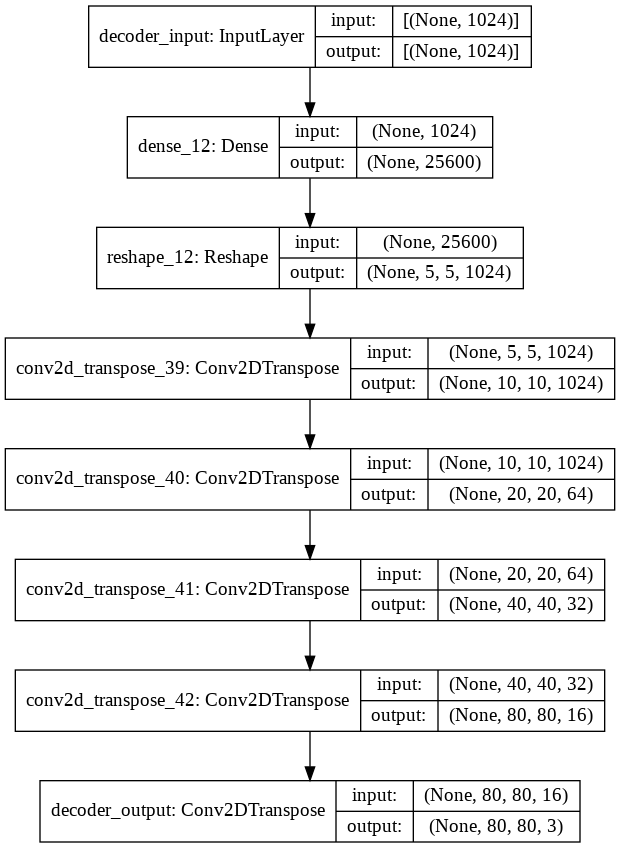

In [111]:
decoder_colorizing.summary()
plot_model(decoder_colorizing, show_shapes=True)

## Auto-codificador: auto-encoder

In [113]:
autoencder_colorizing = Model(inputs, decoder_colorizing(encoder_colorizing(inputs)),
                              name = 'autoencoder_colorizing')

Model: "autoencoder_colorizing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 80, 80, 1)]       0         
_________________________________________________________________
Encoder_Colorizing (Function (None, 1024)              26489008  
_________________________________________________________________
decoder_colorizing (Function (None, 80, 80, 3)         30708019  
Total params: 57,197,027
Trainable params: 57,197,027
Non-trainable params: 0
_________________________________________________________________


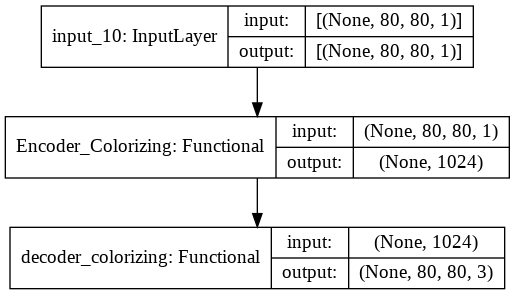

In [114]:
autoencder_colorizing.summary()
plot_model(autoencder_colorizing,show_shapes=True)

# Callbacks

In [115]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

# Compilar

In [116]:
autoencder_colorizing.compile(loss='mse',
                               optimizer = 'adam',
                               metrics = ['mae'])

In [117]:
# Separar datos en entrenamiento y validación interna 
X_train,X_test=train_test_split(X,test_size=0.1, random_state=42)


In [118]:
# Separar datos en entrenamiento y validación interna para imagenes a B/N
X_train_gray,X_test_gray=train_test_split(X_gray,test_size=0.1, random_state=42)

## Entrenar el modelo

In [119]:
history = autoencder_colorizing.fit(X_gray, X,callbacks = callbacks,validation_data = (X_test_gray, X_test),epochs = epochs,batch_size = batch_size)

Epoch 1/20
52/52 [==============================] - 46s 235ms/step - loss: 0.0428 - mae: 0.1686 - val_loss: 0.0349 - val_mae: 0.1502

Epoch 00001: val_loss improved from inf to 0.03492, saving model to /content/saved_models/colorized_ae_model.001.h5
Epoch 2/20
52/52 [==============================] - 11s 220ms/step - loss: 0.0343 - mae: 0.1480 - val_loss: 0.0221 - val_mae: 0.1111

Epoch 00002: val_loss improved from 0.03492 to 0.02206, saving model to /content/saved_models/colorized_ae_model.002.h5
Epoch 3/20
52/52 [==============================] - 12s 225ms/step - loss: 0.0187 - mae: 0.1031 - val_loss: 0.0130 - val_mae: 0.0851

Epoch 00003: val_loss improved from 0.02206 to 0.01300, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/20
52/52 [==============================] - 12s 227ms/step - loss: 0.0123 - mae: 0.0831 - val_loss: 0.0107 - val_mae: 0.0771

Epoch 00004: val_loss improved from 0.01300 to 0.01072, saving model to /content/saved_models/colorized_ae_m

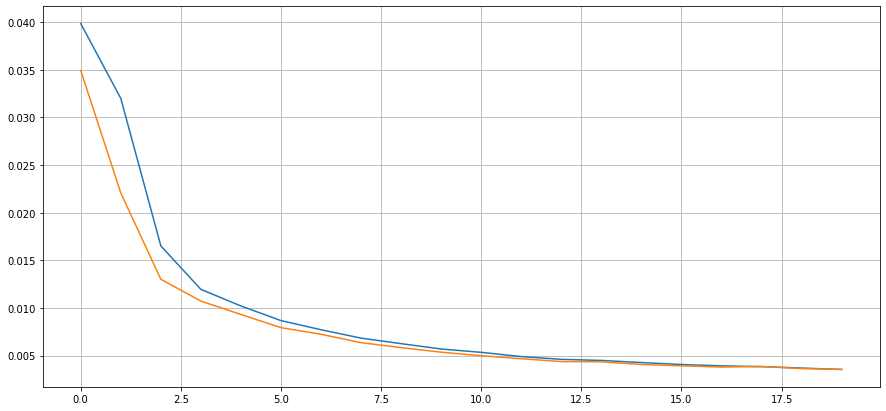

In [121]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

# Predicciones y gráficas

In [122]:
x_decoded = autoencder_colorizing.predict(X_gray)

# Imágenes coloreadas con la predicción

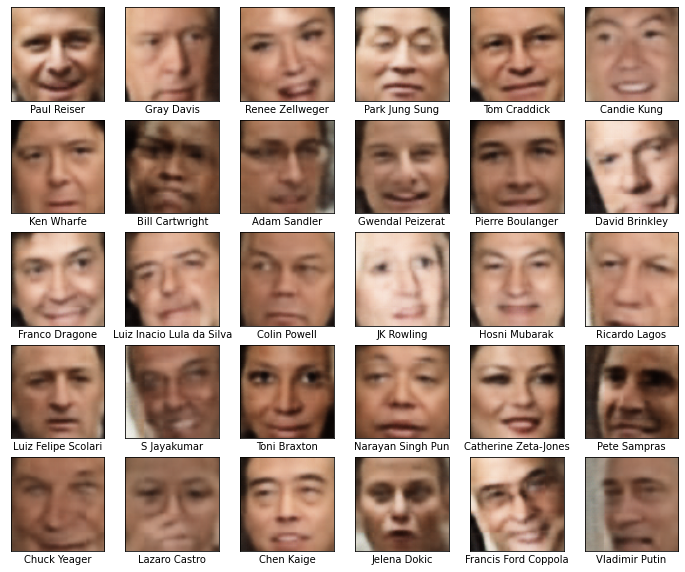

In [123]:
plt.figure(figsize = (12,10))
numero_muestras = 30
muestras = np.random.randint(0, len(x_decoded), numero_muestras)

for i in range(numero_muestras):
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_decoded[muestras[i]])
  plt.xlabel(names.person[muestras[i]])
plt.show()

In [124]:
print(X.shape)
print(X_gray.shape)

(13143, 80, 80, 3)
(13143, 80, 80, 1)


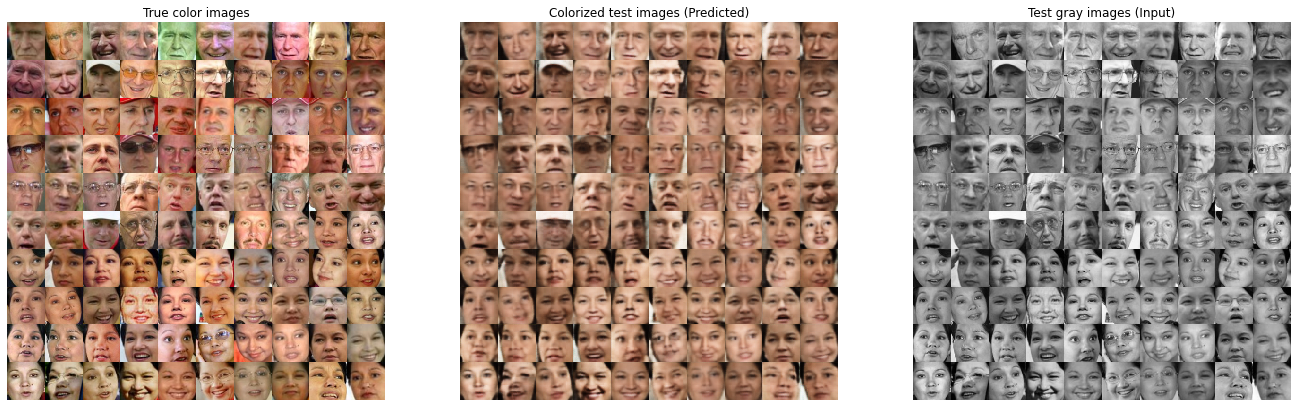

In [125]:
plt.figure(figsize=(23,23))

img_rows = rows
img_cols = cols 

# Imagenes reales
plt.subplot(131)
imgs_t = X[:100]
imgs_t = imgs_t.reshape((10,10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('True color images')
plt.imshow(imgs_t, interpolation='none')

# Imagenes PREDICHAS
 
plt.subplot(132)
imgs = x_decoded[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')


# Imagenes a B/N 
plt.subplot(133)

imgs_g = X_gray[:100]
imgs_g = imgs_g.reshape((10,10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs_g, interpolation='none', cmap='gray')

plt.show()




# PREDICCIÓN CON UNA FOTO

In [127]:
import cv2
from PIL import Image 

In [129]:
from google.colab import files
imagesbn = files.upload()

Saving IMG-20160311-WA0002.jpg to IMG-20160311-WA0002.jpg


In [130]:
mi_foto_gris = Image.open('/content/IMG-20160311-WA0002.jpg')
mi_foto_gris = mi_foto_gris.convert('L')

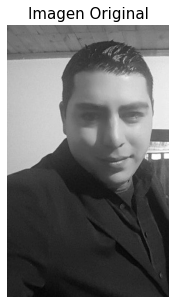

In [131]:
plt.figure(figsize=(5,5))
plt.title('Imagen Original', fontsize = 15)
plt.imshow(mi_foto_gris, cmap='gray')

plt.axis('off')
plt.show()

# Normalizar el la imagen de entrada

In [133]:
mi_foto_gris_norm = (np.array(mi_foto_gris))/255. 

print('La forma fde la imagen reducida es:', mi_foto_gris_norm.shape)
mi_foto_gris_norm = cv2.resize(mi_foto_gris_norm,(80,80)).flatten()
print('Data flatten',mi_foto_gris_norm.shape)
mi_foto_gris_norm = np.array(mi_foto_gris_norm).reshape(1,80,80,1)
print('Nueva forma de los datos:', mi_foto_gris_norm.shape)

La forma fde la imagen reducida es: (507, 302)
Data flatten (6400,)
Nueva forma de los datos: (1, 80, 80, 1)


In [134]:
Mi_Foto_Color = autoencder_colorizing.predict(mi_foto_gris_norm)
print('La dimensión de mi foto es de',Mi_Foto_Color.shape)

La dimensión de mi foto es de (1, 80, 80, 3)


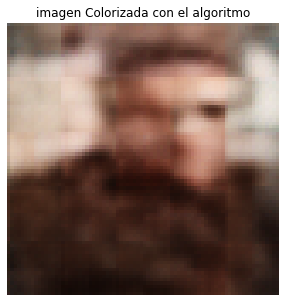

In [140]:
imgs = Mi_Foto_Color
imgs = imgs.reshape((img_rows, img_cols, channels))
plt.figure(figsize=(5,5))
plt.title('imagen Colorizada con el algoritmo')
plt.imshow(imgs)
plt.axis('off')
plt.show()

In [ ]:
imgs = Mi_Foto_Color
imgs = imgs.reshape((img_rows, img_cols, channels))
plt.figure(figsize=(5,5))
plt.title('imagen Colorizada con el algoritmo')
plt.imshow(imgs)
plt.savefig('./test_color.png')
plt.axis('off')
plt.show()

In [ ]:
from google.colab import files
imagesbn = files.upload()

Saving aaaa.png to aaaa.png


In [ ]:
mi_foto_gris = Image.open('//content/aaaa.png')
mi_foto_gris = mi_foto_gris.convert('L')

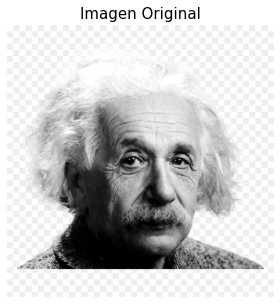

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Imagen Original', fontsize = 15)
plt.imshow(mi_foto_gris, cmap='gray')

plt.axis('off')
plt.show()

In [ ]:
mi_foto_gris_norm = (np.array(mi_foto_gris))/255. 

print('La forma fde la imagen reducida es:', mi_foto_gris_norm.shape)
mi_foto_gris_norm = cv2.resize(mi_foto_gris_norm,(64,64)).flatten()
print('Data flatten',mi_foto_gris_norm.shape)
mi_foto_gris_norm = np.array(mi_foto_gris_norm).reshape(1,64,64,1)

print('Nueva forma de los datos:', mi_foto_gris_norm.shape)

La forma fde la imagen reducida es: (877, 860)
Data flatten (4096,)
Nueva forma de los datos: (1, 64, 64, 1)


In [ ]:
Mi_Foto_Color = autoencder_colorizing.predict(mi_foto_gris_norm)
print('La dimensión de mi foto es de',Mi_Foto_Color.shape)

La dimensión de mi foto es de (1, 64, 64, 3)


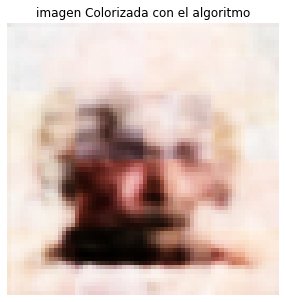

In [ ]:
imgs = Mi_Foto_Color
imgs = imgs.reshape((img_rows, img_cols, channels))
plt.figure(figsize=(5,5))
plt.title('imagen Colorizada con el algoritmo')
plt.imshow(imgs)
plt.axis('off')
plt.show()